<a href="https://colab.research.google.com/github/mshokarimo7/pedestrian_dynamics_estimation/blob/main/Copy_of_how_to_track_and_count_vehicles_with_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jan 30 15:12:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
%cd /content
HOME = os.getcwd()
print(HOME)
#Setting the Drive to upload the dataset and setting the Source Video Path
from google.colab import drive
drive.mount('/content/drive')

/content
/content
Mounted at /content/drive


In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.17

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## Install ByteTrack

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()

import sys
sys.path.append(f"{HOME}/ByteTrack")

import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0

from IPython import display
display.clear_output()

import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from tqdm.notebook import tqdm
import cv2
import csv

## Tracking utils

In [ ]:
from typing import List
import numpy as np

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 188MB/s]

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [0]

##Run on a single video

In [ ]:
JAAD_PATH = f"{HOME}/drive/MyDrive/MOT15"
video_file = "TUD-Stadtmitte.mkv"
SOURCE_VIDEO_PATH = os.path.join(JAAD_PATH, video_file)
video_name = os.path.basename(SOURCE_VIDEO_PATH)
print(video_name)
TARGET_VIDEO_PATH = f"{HOME}/drive/MyDrive/TrackerOutputs/SingleVideo/{video_name}" # video file path where the tracker outputs video
output_csv_file = f"{HOME}/drive/MyDrive/CSVOutputs/SingleVideo/{video_name}.csv" # cSV file path of the tracker outputs

# defining the CSV column names
csv_columns = [
    '<frame>',
    '<id>',
    '<bb_left>',
    '<bb_top>',
    '<bb_width>',
    '<bb_height>',
    '<conf>',
    '<x>',
    '<y>',
    '<z>'
]

# opening the CSV file for writing
csv_file = open(output_csv_file, 'w', newline='')
csv_writer = csv.DictWriter(csv_file, fieldnames=csv_columns)

# writing the header row
csv_writer.writeheader()

# BYTETracker running
byte_tracker = BYTETracker(BYTETrackerArgs())
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.4)

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
  for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)[0]
        """
        Creating a detections variable which finds the
        XY coordinates of objects,
        confidence in the detected object
        class id of the object, in this snipped of code -> enumerated id from the YOLO models
        """
        detections = Detections(
            xyxy=results.boxes.xyxy.cpu().numpy(),
            confidence=results.boxes.conf.cpu().numpy(),
            class_id=results.boxes.cls.cpu().numpy().astype(int)
        )

        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # where we are actually using ByteTrack to track the objects
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )

        # where we make the iou and choose detection bboxes that are closest to tracklet bboxes and save their tracker_id
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # filtering out detections without trackers --- THE TWO LINES BELOW SOLVED THE TRICK WITH
        # THE FRAMES NOT BEING ABLE TO RUN PAST 18 frames "IndexError: index 0 is out of bounds for axis 0 with size 0"
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)


        """ recreating a new list of rearranged tracklets according to the tracker_id array
        creating a dictionary to map 'track_id' values to their corresponding objects """
        track_id_to_object = {track.track_id: track for track in tracks}

        # a list to store rearranged objects
        rearranged_tracks = []

        # iterating through the 'tracker_id' array
        for tracker_ids in tracker_id:
            # checking if theres a corresponding object in the dictionary
            if tracker_ids in track_id_to_object:
                # appending the object to the list of rearranged objects
                rearranged_tracks.append(track_id_to_object[tracker_ids])
                # removing the object from the dictionary to avoid duplicates
                del track_id_to_object[tracker_ids]
        # rearranged_tracks contains the objects sorted based on the 'tracker_id' array

        xyz = -1
        # iterating through rearranged_tracks and writing each STrack to the CSV file
        for track in rearranged_tracks:
          # extracting the values we want from the tracklet
          frame_csv = track.frame_id
          track_id = track.track_id
          # extracting the 'tlwh' instead of '_tlwh' makes the accuracy much better
          tlwh = track.tlwh
          score = track.score
          # extracting individual values for bb_left, bb_top, bb_width, and bb_height
          # tlwh - top left width height
          bb_left, bb_top, bb_width, bb_height = tlwh[0], tlwh[1], tlwh[2], tlwh[3]
          # creating a dictionary to represent the row to write into our csv file
          row = {
              '<frame>': frame_csv,
              '<id>': track_id,
              '<bb_left>': bb_left,
              '<bb_top>': bb_top,
              '<bb_width>': bb_width,
              '<bb_height>': bb_height,
              '<conf>': score,
              '<x>': xyz,
              '<y>': xyz,
              '<z>': xyz
          }
          # writing the row to the CSV file
          csv_writer.writerow(row)

        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]

        rearranged_tracks.clear()
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        sink.write_frame(frame)

csv_file.close()

TUD-Stadtmitte.mkv


  0%|          | 0/179 [00:00<?, ?it/s]

##Run on all the videos

In [ ]:
JAAD_PATH = f"{HOME}/drive/MyDrive/JAAD/JAAD_clips"
video_files = [file for file in os.listdir(JAAD_PATH) if file.endswith(".mp4")]

for video_file in video_files:
    # clearing variables just in case we have trailing ones after each video iteration
    video_name = None
    SOURCE_VIDEO_PATH = None
    TARGET_VIDEO_PATH = None
    output_csv_file = None
    csv_file = None
    csv_writer = None
    csv_columns = None
    byte_tracker = None
    generator = None
    box_annotator = None
    video_info = None
    results = None
    detections = None
    mask = None
    tracks = None
    tracker_id = None
    track_id_to_object = None
    rearranged_tracks = None
    labels = None

    # creating proper paths
    SOURCE_VIDEO_PATH = os.path.join(JAAD_PATH, video_file)
    video_name = os.path.basename(SOURCE_VIDEO_PATH)
    print(video_name)
    TARGET_VIDEO_PATH = f"{HOME}/drive/MyDrive/TrackerOutputs/{video_name}" # video file path where the tracker outputs video
    output_csv_file = f"{HOME}/drive/MyDrive/CSVOutputs/{video_name}.csv" # CSV file path of the tracker outputs

    # defining the CSV column names
    csv_columns = [
        '<frame>',
        '<id>',
        '<bb_left>',
        '<bb_top>',
        '<bb_width>',
        '<bb_height>',
        '<conf>',
        '<x>',
        '<y>',
        '<z>'
    ]

    # opening the CSV file for writing
    csv_file = open(output_csv_file, 'w', newline='')
    csv_writer = csv.DictWriter(csv_file, fieldnames=csv_columns)

    # writing the header row
    csv_writer.writeheader()

    # creating the BYTETracker variable for later runtime
    byte_tracker = BYTETracker(BYTETrackerArgs())
    generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

    box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.4)

    video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

    # looping over the frames
    with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
      for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)[0]
        """
        Creating a detections variable which finds the
        XY coordinates of objects,
        confidence in the detected object,
        class id of the object, in this snippet of code -> enumerated id from the YOLO models
        """
        detections = Detections(
            xyxy=results.boxes.xyxy.cpu().numpy(),
            confidence=results.boxes.conf.cpu().numpy(),
            class_id=results.boxes.cls.cpu().numpy().astype(int)
        )

        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # using ByteTrack to track the objects, and storing the tracklets
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )

        # matching the tracklet bounding boxes with the detections' bounding boxes
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # getting rid of detections that are not being tracked
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        """
        recreating a new list of rearranged tracklets according to the tracker_id array
        creating a dictionary to map 'track_id' values to their corresponding objects
        """
        track_id_to_object = {track.track_id: track for track in tracks}

        # creating a list to store rearranged objects
        rearranged_tracks = []

        # iterating through the 'tracker_id' array
        for tracker_ids in tracker_id:
            # checking if theres a corresponding object in the dictionary
            if tracker_ids in track_id_to_object:
                # appending the object to the list of rearranged objects
                rearranged_tracks.append(track_id_to_object[tracker_ids])
                # removing the object from the dictionary to avoid duplicates
                del track_id_to_object[tracker_ids]
        # rearranged_tracks contains the objects sorted based on the 'tracker_id' array


        xyz = -1
        # iterating through rearranged_tracks and writing each STrack to the CSV file
        for track in rearranged_tracks:
          # extracting the values we want from the tracklet
          frame_csv = track.frame_id
          track_id = track.track_id
          # extracting the 'tlwh' instead of '_tlwh' makes the accuracy much better
          tlwh = track.tlwh
          score = track.score
          # extracting individual values for bb_left, bb_top, bb_width, and bb_height
          # tlwh -> top left width height
          bb_left, bb_top, bb_width, bb_height = tlwh[0], tlwh[1], tlwh[2], tlwh[3]
          # creating a dictionary to represent the row to write into our csv file
          row = {
              '<frame>': frame_csv,
              '<id>': track_id,
              '<bb_left>': bb_left,
              '<bb_top>': bb_top,
              '<bb_width>': bb_width,
              '<bb_height>': bb_height,
              '<conf>': score,
              '<x>': xyz,
              '<y>': xyz,
              '<z>': xyz
          }
          # writing the row to the CSV file
          csv_writer.writerow(row)

        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        rearranged_tracks.clear()
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        sink.write_frame(frame)

    csv_file.close()

##Calculate Pedestrian speeds from detections and visualize on a video(bounding box format, without euclidian distance)

In [ ]:
JAAD_PATH = f"{HOME}/drive/MyDrive/JAAD/JAAD_clips"
video_file = "video_0001.mp4"
SOURCE_VIDEO_PATH = os.path.join(JAAD_PATH, video_file)
video_name = os.path.basename(SOURCE_VIDEO_PATH)
print(video_name)
TARGET_VIDEO_PATH = f"{HOME}/without_euclid.mp4"

# BYTETracker running
byte_tracker = BYTETracker(BYTETrackerArgs())
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.4)

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

prev_detections = None

with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    with open(f'{HOME}/output.txt', 'w') as f:
        for frame in tqdm(generator, total=video_info.total_frames):
            results = model(frame)[0]
            """
            Creating a detections variable which finds the
            XY coordinates of objects,
            confidence in the detected object
            class id of the object, in this snipped of code -> enumerated id from the YOLO models
            """
            detections = Detections(
                xyxy=results.boxes.xyxy.cpu().numpy(),
                confidence=results.boxes.conf.cpu().numpy(),
                class_id=results.boxes.cls.cpu().numpy().astype(int)
            )

            # filtering out detections with unwanted classes
            mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
            detections.filter(mask=mask, inplace=True)

            # where we are actually using ByteTrack to track the objects
            tracks = byte_tracker.update(
                output_results=detections2boxes(detections=detections),
                img_info=frame.shape,
                img_size=frame.shape
            )

            tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
            detections.tracker_id = np.array(tracker_id)

            # filtering out detections without trackers --- THE TWO LINES BELOW SOLVED THE TRICK WITH
            # THE FRAMES NOT BEING ABLE TO RUN PAST 18 frames "IndexError: index 0 is out of bounds for axis 0 with size 0"
            mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
            detections.filter(mask=mask, inplace=True)

            # dictionary to store the bbox difference
            xyxy_diff_dict = {}

            if prev_detections is not None:
                # creating a dictionary, mapping tracker_id to xyxy for prev_detections
                prev_dict = {detection[-1]: detection[0] for detection in prev_detections}

                # creating a dictionary, mapping tracker_id to xyxy for detections
                current_dict = {detection[-1]: detection[0] for detection in detections}

                """
                For each tracker_id in current detections, if it also exists in prev_detections,
                calculate the difference between the xyxy values
                """

                for tracker_id in current_dict:
                    if tracker_id in prev_dict:
                        xyxy_diff = current_dict[tracker_id] - prev_dict[tracker_id]
                        xyxy_diff_dict[tracker_id] = xyxy_diff  # storings xyxy_diff in another dictionary, which is mapped to tracker_id

            prev_detections = detections

            labels = [
                f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f} xyxy_diff = {xyxy_diff_dict.get(tracker_id)}"
                for _, confidence, class_id, tracker_id
                in detections
            ]

            frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
            sink.write_frame(frame)

##Calculate Pedestrian speeds from detections and visualize on a video(bounding box format, with euclidian distance)

In [ ]:
import pandas as pd

JAAD_PATH = f"{HOME}/drive/MyDrive/JAAD/JAAD_clips"
video_file = "video_0001.mp4"
SOURCE_VIDEO_PATH = os.path.join(JAAD_PATH, video_file)
video_name = os.path.basename(SOURCE_VIDEO_PATH)
print(video_name)
TARGET_VIDEO_PATH = f"{HOME}/output1.mp4"

# BYTETracker running
byte_tracker = BYTETracker(BYTETrackerArgs())
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = BoxAnnotator(color=ColorPalette.from_hex(['#04b09f']), thickness=1, text_thickness=1, text_scale=0.4)

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

prev_detections = None
frame_num = 0
# initializing an empty DataFrame to store the results
df = pd.DataFrame(columns=['<frame>', '<id>', '<speed>'])

with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)[0]
        """
        Creating a detections variable which finds the
        XY coordinates of objects,
        confidence in the detected object
        class id of the object, in this snipped of code -> enumerated id from the YOLO models
        """
        detections = Detections(
            xyxy=results.boxes.xyxy.cpu().numpy(),
            confidence=results.boxes.conf.cpu().numpy(),
            class_id=results.boxes.cls.cpu().numpy().astype(int)
        )

        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # where we are actually using ByteTrack to track the objects
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )

        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # filtering out detections without trackers --- THE TWO LINES BELOW SOLVED THE TRICK WITH
        # THE FRAMES NOT BEING ABLE TO RUN PAST 18 frames "IndexError: index 0 is out of bounds for axis 0 with size 0"
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # dictionary to store the bbox difference
        xyxy_diff_dict = {}

        #if prev_detections is not empty:
        if prev_detections is not None:
            # creating a dictionary mapping tracker_id to xyxy for prev_detections
            prev_dict = {detection[-1]: detection[0] for detection in prev_detections}

            # creating a dictionary mapping tracker_id to xyxy for detections
            current_dict = {detection[-1]: detection[0] for detection in detections}


            # for each tracker_id in current detections, if it also exists in prev_detections,
            # calculate the difference between the xyxy values
            for tracker_id in current_dict:
                if tracker_id in prev_dict:
                    # center of the bbox for the previous frame
                    x1, y1, w1, h1 = prev_dict[tracker_id]
                    x2, y2 = x1 + w1, y1 + h1
                    center_box1 = ((x1 + x2) / 2, (y1 + y2) / 2)

                    # center of the bbox for the current frame
                    x1_current, y1_current, w1_current, h1_current = current_dict[tracker_id]
                    x2_current, y2_current = x1_current + w1_current, y1_current + h1_current
                    center_box2 = ((x1_current + x2_current) / 2, (y1_current + y2_current) / 2)

                    # calculating the Euclidean distance between the two centers
                    xyxy_diff = np.sqrt((center_box2[0] - center_box1[0])**2 + (center_box2[1] - center_box1[1])**2)

                    xyxy_diff_dict[tracker_id] = round(xyxy_diff, 4)  # storing xyxy_diff in a dictionary, which is mapped to tracker_id

                    # storing the frame number, id, and calculated speed
                    df = df.append({'<frame>': frame_num, '<id>': tracker_id, '<speed>': xyxy_diff}, ignore_index=True)

        prev_detections = detections
        frame_num = frame_num + 1

        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f} speed = {xyxy_diff_dict.get(tracker_id)}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        sink.write_frame(frame)

# writing the results DataFrame to a new CSV file
df = df.sort_values(by=['<frame>'])
df.to_csv(f'{HOME}/speeds.csv', index=False)

##Pedestrians speed visualize

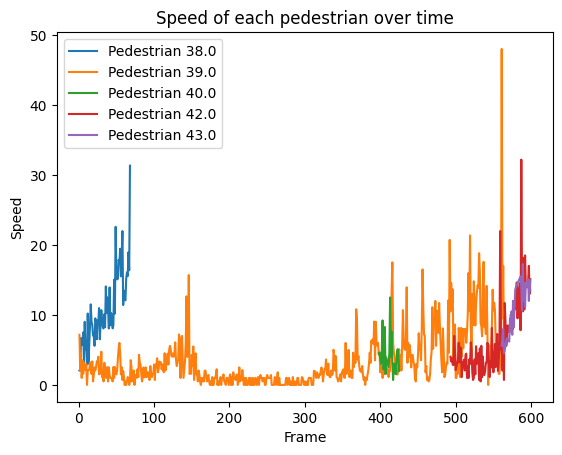

In [ ]:
import matplotlib.pyplot as plt

# reading the speeds.csv file
df = pd.read_csv(f'{HOME}/speeds.csv')

# getting the unique pedestrian ids
ids = df['<id>'].unique()

# creating a new figure
plt.figure()

# for each id, plotting the speed over time
for id in ids:
    id_df = df[df['<id>'] == id]
    plt.plot(id_df['<frame>'], id_df['<speed>'], label=f'Pedestrian {id}')

# adding a legend, title, and labels
plt.legend()
plt.title('Speed of each pedestrian over time')
plt.xlabel('Frame')
plt.ylabel('Speed')

plt.show()

##Converting the .csv file into .txt file for TrackEval

---



In [ ]:
# converting the comma seperated CSV file into a text file with Comma separation

# for the path values we can either specify the ground truth CSV files or the tracker data CSV files
csv_folder = f'{HOME}/drive/MyDrive/CSVOutputs/SingleVideo'
output_folder = f'{HOME}/drive/MyDrive/MOT15/TextFormat'

for filename in os.listdir(csv_folder):
    if filename.endswith(".csv"):
      csv_file = os.path.join(csv_folder, filename)
      txt_file = os.path.join(output_folder, f"{os.path.splitext(filename)[0].replace('.mkv', '')}.txt")

      # processing the CSV file and save as a text file
      with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
           [my_output_file.write(",".join(row) + '\n') for row in csv.reader(my_input_file)]

      # removing the header from the generated text file
      with open(txt_file, 'r') as fin:
        data = fin.read().splitlines(True)
      with open(txt_file, 'w') as fout:
        fout.writelines(data[1:])

##Creating the folders, subfolders and files inside the TrackEval/data/gt/mot_challenge/JAAD-train folder

In [ ]:
# setting the base path
base_path = f'{HOME}/drive/MyDrive/TrackEval/data/gt/mot_challenge/JAAD-train'
JAAD_PATH = f"{HOME}/drive/MyDrive/JAAD/JAAD_clips"

# creating folders and files
for i in range(1, 347):
    video_folder = os.path.join(base_path, f'video_{i:04d}')
    gt_folder = os.path.join(video_folder, 'gt')
    seqinfo_file = os.path.join(video_folder, 'seqinfo.ini')

    # creating the video folders
    os.makedirs(video_folder, exist_ok=True)

    # creating the gt folders
    os.makedirs(gt_folder, exist_ok=True)

    # getting video file path
    video_file = os.path.join(JAAD_PATH, f'video_{i:04d}.mp4')


    # extracting the video info
    cap = cv2.VideoCapture(video_file)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    seq_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    im_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    im_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    # creating seqinfo.ini files and populating them
    with open(seqinfo_file, 'w') as seqinfo:
        seqinfo.write('[Sequence]\n')
        seqinfo.write(f'name=video_{i:04d}\n')
        seqinfo.write('imDir=img1\n')
        seqinfo.write(f'frameRate={frame_rate}\n')
        seqinfo.write(f'seqLength={seq_length}\n')
        seqinfo.write(f'imWidth={im_width}\n')
        seqinfo.write(f'imHeight={im_height}\n')
        seqinfo.write('imExt=.jpg\n')

In [ ]:
import os
import shutil

# source directory containing the text format CSV files
source_directory = f'{HOME}/drive/MyDrive/JAAD/Conversion/TextFormat'

# destination directory of ground truth
destination_directory = f'{HOME}/drive/MyDrive/TrackEval/data/gt/mot_challenge/JAAD-train'

# looping through all subfolders in the destination directory
for subfolder in os.listdir(destination_directory):
    subfolder_path = os.path.join(destination_directory, subfolder)

    # checking if the subfolder has a 'gt' folder
    gt_folder_path = os.path.join(subfolder_path, 'gt')
    if os.path.exists(gt_folder_path) and os.path.isdir(gt_folder_path):
        # creating the source file path based on the subfolder name
        source_file_path = os.path.join(source_directory, f"{subfolder}.txt")

        # creating the destination file path
        destination_file_path = os.path.join(gt_folder_path, 'gt.txt')

        # checking if the source file exists
        if os.path.exists(source_file_path):
            # copying the ground truth .txt file to the destination folder
            shutil.copy(source_file_path, destination_file_path)
            print(f"copied {source_file_path} to {destination_file_path}")
        else:
            print(f"source file {source_file_path} not found for {subfolder}")
    else:
        print(f"no 'gt' folder found for {subfolder}")


##Creating the subfolderfolders and files inside the TrackEval/data/trackers/mot_challenge/JAAD-train

In [ ]:
import shutil
# setting the source and destination folders
source_folder = f'{HOME}/drive/MyDrive/CSVOutputs/TxtOutputs'
destination_folder = f'{HOME}/drive/MyDrive/TrackEval/data/trackers/mot_challenge/JAAD-train/BYTETrack/data'

# iterating over each file in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith('.txt'):
        source_file = os.path.join(source_folder, filename)
        destination_file = os.path.join(destination_folder, filename)

        # copying the file to the destination folder
        shutil.copyfile(source_file, destination_file)

##Track eval another one

In [ ]:
%cd {HOME}/drive/MyDrive/TrackEval/scripts
!python run_mot_challenge.py --BENCHMARK JAAD --SPLIT_TO_EVAL train --TRACKERS_TO_EVAL BYTETrack --METRICS Identity HOTA --USE_PARALLEL False --NUM_PARALLEL_CORES 1 --DO_PREPROC False
%cd {HOME}

## Running the TrackEval

In [ ]:
%cd {HOME}/drive/MyDrive/TrackEval/scripts
!python run_mot_challenge.py --BENCHMARK JAAD --SPLIT_TO_EVAL train --TRACKERS_TO_EVAL BYTETrack --METRICS Identity CLEAR --USE_PARALLEL False --NUM_PARALLEL_CORES 1 --DO_PREPROC False
%cd {HOME}


##Changing the JAAD xml annotations into into CSV Style .txt, so that we are able to feed it as the groundtruth into TrackEval

In [ ]:
import xml.etree.ElementTree as ET
import os
import csv

# input and output directories
input_dir = f'{HOME}/drive/MyDrive/JAAD/annotations'
output_dir = f'{HOME}/drive/MyDrive/JAAD/Conversion'

# creating the output directory if it doesnt exist
os.makedirs(output_dir, exist_ok=True)

# function to process each XML file
def process_xml_file(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    data_list = []

    # creating a variable to later map the aplhanumeric ids into integer ids
    id_mapping = {}
    id_counter = 1

    for track in root.findall('.//track'):
        if track.get('label') in ['pedestrian', 'ped']:
            for box in track.findall('.//box'):
                # shifting the frame number to +1 to avoid errors whilst running TrackEval
                frame = int(box.get('frame')) + 1
                id_element = box.find(".//attribute[@name='id']").text

                if id_element in id_mapping:
                    id_int = id_mapping[id_element]
                else:
                    id_int = id_counter
                    id_mapping[id_element] = id_counter
                    id_counter += 1

                xbr = box.get('xbr')
                xtl = box.get('xtl')
                ybr = box.get('ybr')
                ytl = box.get('ytl')

                new_width = float(xbr) - float(xtl)
                new_height = float(ybr) - float(ytl)

                occlusion = box.find(".//attribute[@name='occlusion']").text
                conf = 0 if occlusion == 'full' else 1

                data_list.append([frame, id_int, xtl, ytl, new_width, new_height, conf, -1, -1, -1])

    data_list.sort(key=lambda x: int(x[0]))

    # constructing the output CSV file path
    output_csv_file = os.path.join(output_dir, os.path.basename(xml_file).replace('.xml', '.csv'))

    # writing the extracted data to a CSV file
    with open(output_csv_file, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'])
        csvwriter.writerows(data_list)

# iterating through all XML files in the input directory
for xml_file_name in os.listdir(input_dir):
    if xml_file_name.endswith('.xml'):
        xml_file_path = os.path.join(input_dir, xml_file_name)
        process_xml_file(xml_file_path)

##Convert a single JAAD xml annotation file into csv

In [ ]:
import xml.etree.ElementTree as ET
# parsing the XML file
tree = ET.parse('/content/drive/MyDrive/JAAD/annotations/video_0003.xml')
root = tree.getroot()

# creating a list to store the extracted data
data_list = []

# creating a variable to later map the aplhanumeric ids into integer ids
id_mapping = {}
id_counter = 0

# iterating through the track elements
for track in root.findall('.//track'):
    if track.get('label') in ['pedestrian', 'ped']:
        for box in track.findall('.//box'):
            frame = box.get('frame')
            id_element = box.find(".//attribute[@name='id']").text

            # converting the alphanumeric value of the 'ids' into numeric values
            if id_element in id_mapping:
              id_int = id_mapping[id_element]
            else:
              id_int = id_counter
              id_mapping[id_element] = id_counter
              id_counter += 1

            xbr = box.get('xbr')
            xtl = box.get('xtl')
            ybr = box.get('ybr')
            ytl = box.get('ytl')

            # changing the bottom right corner coordinates into bbox width and height
            new_width = float(xbr) - float(xtl)
            new_height = float(ybr) - float(ytl)

            # converting the occlusion values into 1 or 0
            occlusion = box.find(".//attribute[@name='occlusion']").text
            conf = 0 if occlusion == 'full' else 1

            data_list.append([frame, id_int, xtl, ytl, new_width, new_height, conf, -1, -1, -1])

data_list.sort(key=lambda x: int(x[0]))

# writing the extracted data to a CSV file
with open('/content/drive/MyDrive/JAAD/Conversion/output3.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'])
    csvwriter.writerows(data_list)
